In [2]:
import tensorflow as tf
import matplotlib as plb
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import preprocess_input


Setup for my budget RTX

In [3]:
# import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("VRAM Growth: ENABLED")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Data Insertion

In [ ]:
ds_mild_dem = "E:/College Stuff/Coding Stuff/RM/Data/Mild Dementia"
ds_mod_dem = "E:/College Stuff/Coding Stuff/RM/Data/Moderate Dementia"
ds_non_dem = "E:/College Stuff/Coding Stuff/RM/Data/Non Demented"
ds_very_mild_dem = "E:/College Stuff/Coding Stuff/RM/Data/Very mild Dementia"
ds_dem = "E:\College Stuff\Coding Stuff\RM\Data"


image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    ds_dem,
    labels = "inferred",
    label_mode = 'categorical',
    validation_split=0.2,
    subset="training",
    seed=1337,
    interpolation='bicubic',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    pad_to_aspect_ratio = True,
)



<>:5: SyntaxWarning: invalid escape sequence '\C'
<>:5: SyntaxWarning: invalid escape sequence '\C'
C:\Users\SN5CD\AppData\Local\Temp\ipykernel_21104\122797349.py:5: SyntaxWarning: invalid escape sequence '\C'
  ds_dem = "E:\College Stuff\Coding Stuff\RM\Data"


Found 86437 files belonging to 4 classes.
Using 69150 files for training.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1.0/255)


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  ds_dem,
  labels = "inferred",
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=1337,
  interpolation='bicubic',
  image_size=image_size,
  batch_size=batch_size,
  shuffle=True,
  pad_to_aspect_ratio = True,
)

Found 86437 files belonging to 4 classes.
Using 17287 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  ds_dem,
  labels = "inferred",
  label_mode='categorical',
  seed=1337,
  interpolation='bicubic',
  image_size=image_size,
  batch_size=batch_size,
  shuffle=True,
  pad_to_aspect_ratio = True,
)

Found 86437 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [ ]:
train_ds = (train_ds.ignore_errors())

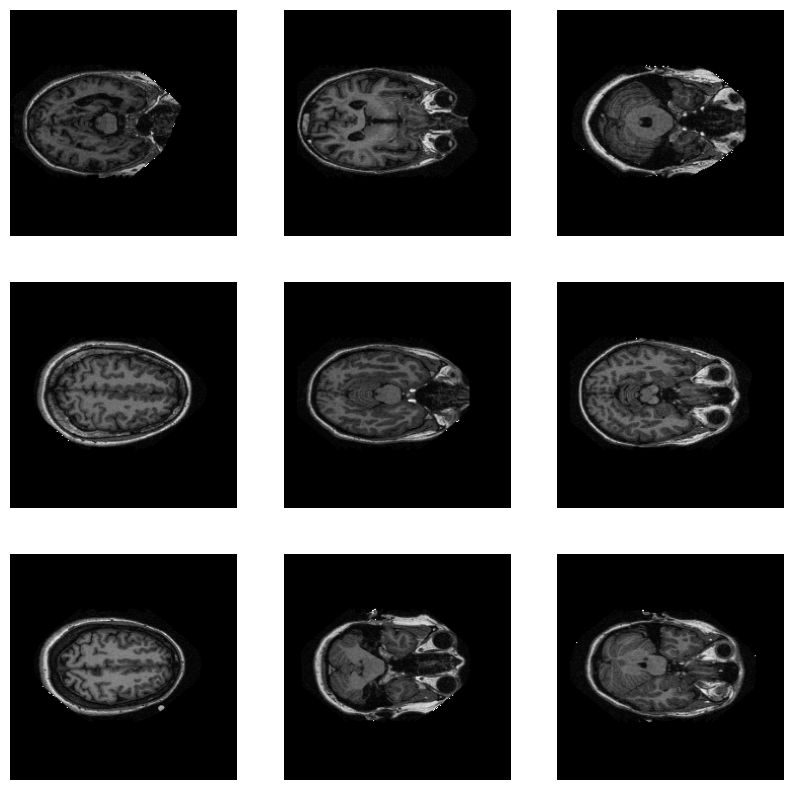

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      # plt.title(int(labels[i]))
      plt.axis("off")

In [ ]:
def fix_pixel_values(image, label):
    image = tf.clip_by_value(image, 0.0, 255.0)  # Clamp values to [0, 255]
    return image, label
train_ds_dem = train_ds.map(fix_pixel_values)
# val_ds = val_ds.map(fix_pixel_values)
# test_ds = test_ds.map(fix_pixel_values)

In [ ]:
def preprocess_image(image, label):
    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)

    image = preprocess_input(image)
    # Normalize to [0, 1]
    # image = tf.cast(image, tf.float32) / 255.0
    # image = tf.image.per_image_standardization(image)
    # image = tf.keras.applications.resnet_v2.preprocess_input(image)



    # Clamp values to valid range
    # image = tf.clip_by_value(image, 0.0, 1.0)

    # Contrast stretching
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    # tf.print(max_val)
    # tf.print(min_val)

    # image = (image - min_val) / (max_val - min_val + 1e-5)  # Avoid division by zero

    # Apply Gaussian filter
    # image = tf.image.gaussian_filter2d(image, filter_shape=(5, 5), sigma=1.0)
    # tf.print("Pixel values after normalization:", tf.reshape(image, [-1])[:5])  # Print the first 100 values

    return image, label

In [ ]:
train_ds_processed = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Normalization function
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_ds_dem = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
train_ds_processed = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_processed = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_processed = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for images, labels in train_ds_processed.take(1):
    print("Normalized min pixel value:", tf.reduce_min(images).numpy())
    print("Normalized max pixel value:", tf.reduce_max(images).numpy())

Normalized min pixel value: -1.0659792
Normalized max pixel value: 1.0153267


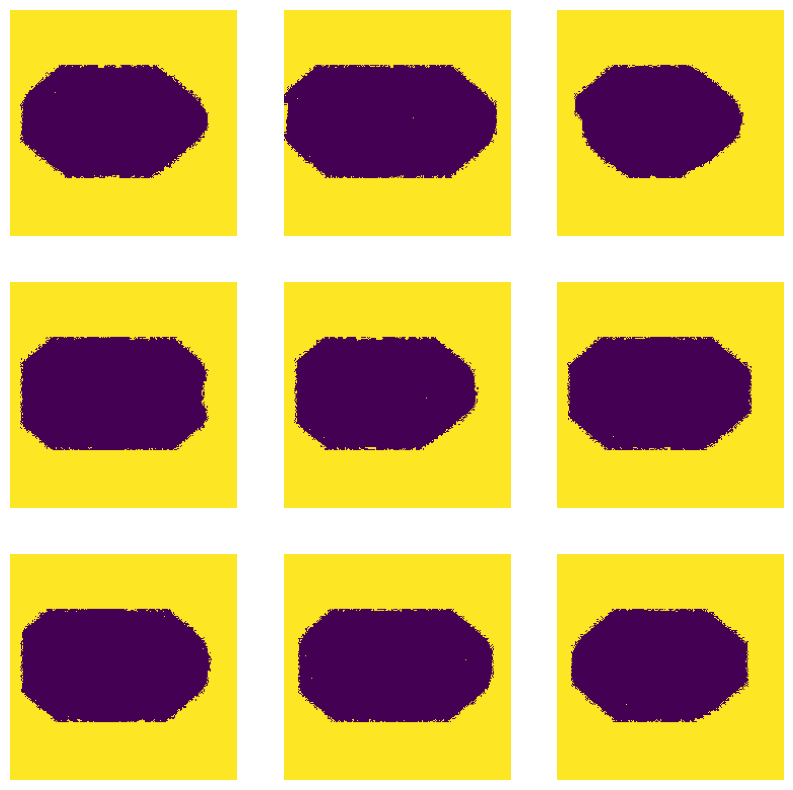

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_processed.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      if labels[i].numpy().size > 1:
            # For 'categorical' labels, find the index of the max value
            label_index = np.argmax(labels[i].numpy())
      else:
          # For 'binary' or 'int' labels in an array, access the first element
          label_index = int(labels[i].numpy()[0])
      plt.axis("off")

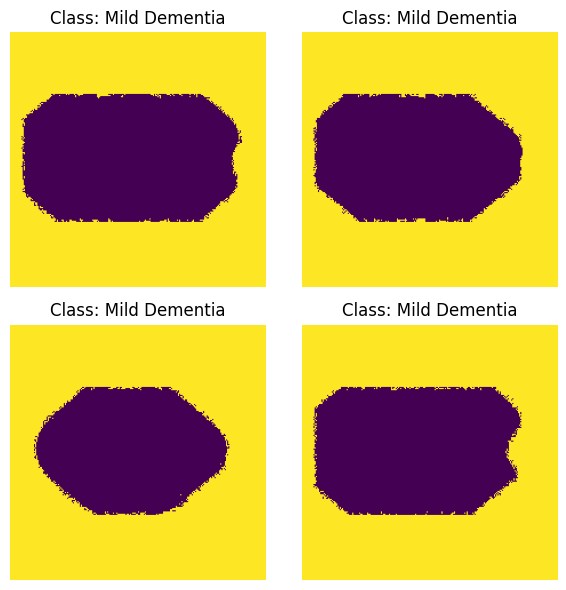

In [ ]:
plt.figure(figsize=(6, 6))  # Adjust figure size for a square layout

# Display 4 images from train_ds_processed
for images, labels in train_ds_processed.take(1):  # Assuming train_ds_processed is defined
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)  # Create a 2x2 grid
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = int(labels[i].numpy()[0])
        # This now works because label_index is a proper integer (0, 1, etc.)
        plt.title(f"Class: {class_names[label_index]}")
        # plt.title(f"Class: {class_names[int(labels[i])]}")
        plt.axis("off")

plt.tight_layout()  # Automatically adjust subplot parameters for a clean layout
plt.show()

Data Augmentation

In [ ]:
def augment_image(image, label):
    # Random rotation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random brightness and contrast adjustments
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random cropping or resizing
    image = tf.image.resize_with_crop_or_pad(image, 256, 256)  # Ensure consistent size
    image = tf.image.random_crop(image, size=[224, 224, 1])

    # Random translation (width and height shifts)
    image = tf.image.resize(image, size=[224 + tf.random.uniform([], -20, 20, dtype=tf.int32),
                                         224 + tf.random.uniform([], -20, 20, dtype=tf.int32)])
    image = tf.image.resize(image, [224, 224])
    image = tf.clip_by_value(image, 0.0, 1.0)  # Clamp values to valid range

    return image, label

In [ ]:
# augment data
train_ds_aug = train_ds_processed.unbatch().map(augment_image).batch(batch_size)
# train_ds_aug = train_ds_aug.repeat()  # Infinite dataset

In [ ]:
for images, labels in train_ds_aug.take(1):
    print("Normalized min pixel value:", tf.reduce_min(images).numpy())
    print("Normalized max pixel value:", tf.reduce_max(images).numpy())

Normalized min pixel value: 0.0
Normalized max pixel value: 1.0


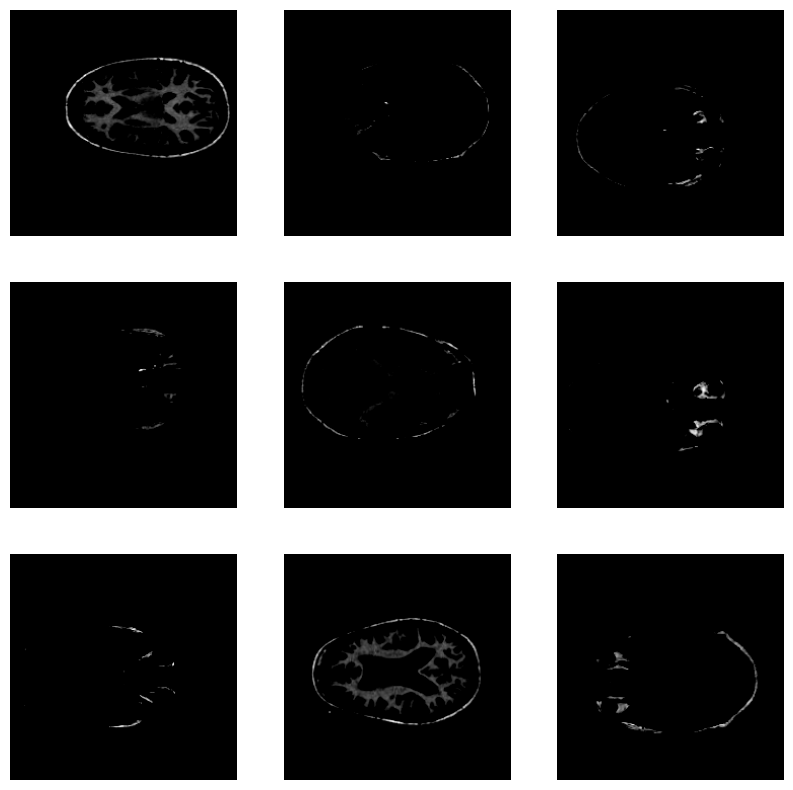

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i], cmap="gray")
      if labels[i].numpy().size > 1:
            # For 'categorical' labels, find the index of the max value
            label_index = np.argmax(labels[i].numpy())
      else:
          # For 'binary' or 'int' labels in an array, access the first element
          label_index = int(labels[i].numpy()[0])
      plt.axis("off")

Model

In [ ]:
# Load the base ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add a convolutional block
x = base_model.output


x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


x = Activation('relu')(x)    # Activation function

x = GlobalAveragePooling2D()(x)  # can use flatten
x = Dropout(0.7)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)  # Final classification layer

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Define an exponential decay schedule
initial_learning_rate = 0.001  # Starting learning rate
num_train_samples = 80000
batch_size = 32
decay_rate = 0.1  # Decay factor (matching exponential_decay_fn)
steps_per_epoch = num_train_samples // batch_size  # Number of batches in training dataset
decay_steps = steps_per_epoch * 20  # 20 epochs equivalent

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False  # If True, decay occurs in discrete steps
)
# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
     

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,488,100 (97.23 MB)

 Trainable params: 1,923,108 (7.34 MB)

 Non-trainable params: 23,564,992 (89.89 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Define the EarlyStopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10,             # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore weights from the best epoch
)

In [ ]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopper]
)
   

Epoch 1/100
    263/Unknown 221s 820ms/step - accuracy: 0.7518 - auc: 0.9035 - loss: 0.7416

KeyboardInterrupt: 